# Modelling of Georgia

## Initial Loading of Packages and data

Small naming correction made for spelling mistakes

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import xgboost as xgb
# Visualizers
import shap

In [2]:
training=pd.read_pickle('data/GA_pickled/training.pkl')
testing=pd.read_pickle('data/GA_pickled/testing.pkl')

In [3]:
training=training.rename(columns={'closest_five_avg_dormrooms_landgrnt':'closest_five_avg_dormrooms_landgrant'})
testing=testing.rename(columns={'closest_five_avg_dormrooms_landgrnt':'closest_five_avg_dormrooms_landgrant'})

In [4]:
# Features are obtained from georga_models
features=['population',
 'per_capita_income',
 'closest_five_r1r2_avg',
 'closest_five_public_avg',
 'closest_five_private_nfp_avg',
 'closest_five_landgrnt_avg',
 'closest_five_stem_avg',
 'closest_five_avg_enrollment_r1r2',
 'closest_five_avg_enrollment_public',
 'closest_five_avg_enrollment_private_nfp',
 'closest_five_avg_enrollment_landgrnt',
 'closest_five_avg_enrollment_stem',
 'closest_five_avg_dormrooms_r1r2',
 'closest_five_avg_dormrooms_public',
 'closest_five_avg_dormrooms_private_nfp',
 'closest_five_avg_dormrooms_landgrant',
 'closest_five_avg_dormrooms_stem']

training.per_capita_income=training.per_capita_income.astype(int)

training[features].head()

,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem
9204,30378,46486,87.433833,46.920303,51.267184,145.003935,87.433833,34447.6,13542.6,2841.8,21914.8,34447.6,7334.6,2045.2,783.8,5643.6,7334.6
10233,26732,43679,101.251858,45.595399,31.446211,152.505291,101.251858,34447.6,10741.0,2331.0,21914.8,34447.6,7334.6,1555.2,640.4,5643.6,7334.6
7345,85038,34395,162.654509,38.492451,109.658732,170.955318,162.654509,28496.4,5139.0,2700.4,21696.0,28496.4,4541.6,707.4,742.6,4156.2,4541.6
10885,20706,33134,163.261041,39.172843,120.751646,178.169320,169.597132,26307.2,5434.0,2807.6,21696.0,28496.4,4653.6,897.4,802.4,4156.2,4541.6
10898,18441,42693,174.075733,68.803195,135.086020,229.752946,216.533166,25848.4,9106.8,5413.8,23627.6,27405.6,4776.6,1296.0,1865.0,5162.2,4772.0


In [5]:
x_train = training.drop(['COUNTY','SCHOOL_DSTRCT_NM', 'TEST_CMPNT_TYP_NM','EXAM_COUNT','EXAMS_3_OR_ABOVE','PERCENT_3_OR_ABOVE','Year','Latitude','Longitude','year'],axis=1)
y_train = training[['PERCENT_3_OR_ABOVE']]
X_train = sm.add_constant(x_train)
unimetric_train = X_train.drop(['population','per_capita_income'],axis=1)
X_train.head()

,const,population,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem,per_capita_income
9204,1.0,30378,87.433833,46.920303,51.267184,145.003935,87.433833,34447.6,13542.6,2841.8,21914.8,34447.6,7334.6,2045.2,783.8,5643.6,7334.6,46486
10233,1.0,26732,101.251858,45.595399,31.446211,152.505291,101.251858,34447.6,10741.0,2331.0,21914.8,34447.6,7334.6,1555.2,640.4,5643.6,7334.6,43679
7345,1.0,85038,162.654509,38.492451,109.658732,170.955318,162.654509,28496.4,5139.0,2700.4,21696.0,28496.4,4541.6,707.4,742.6,4156.2,4541.6,34395
10885,1.0,20706,163.261041,39.172843,120.751646,178.169320,169.597132,26307.2,5434.0,2807.6,21696.0,28496.4,4653.6,897.4,802.4,4156.2,4541.6,33134
10898,1.0,18441,174.075733,68.803195,135.086020,229.752946,216.533166,25848.4,9106.8,5413.8,23627.6,27405.6,4776.6,1296.0,1865.0,5162.2,4772.0,42693


## initial models

In [6]:
full_model = sm.OLS(y_train,X_train).fit()
unimetric_model = sm.OLS(y_train,unimetric_train).fit()
nonuni_model = smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income + population', data=training).fit()
unidistance_model = smf.ols('PERCENT_3_OR_ABOVE ~ closest_five_r1r2_avg + closest_five_public_avg + closest_five_private_nfp_avg + closest_five_landgrnt_avg + closest_five_stem_avg', data = training).fit()
pci_model=smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income', data =training).fit()

In [7]:
f_test_nonuni = full_model.compare_f_test(nonuni_model)
f_test_unimetric = full_model.compare_f_test(unimetric_model)
f_test_unidistance = unimetric_model.compare_f_test(unidistance_model)
print("p-value of full compared to non-university metric model:", f_test_nonuni[1])
print("p-value of full compared to university metric model:", f_test_unimetric[1])
print("p-value of university metric compared to university distance model:", f_test_unidistance[1])

p-value of full compared to non-university metric model: 1.661605125935115e-67
p-value of full compared to university metric model: 3.347931279993942e-39
p-value of university metric compared to university distance model: 9.794429313321457e-37


In [8]:
uni_features = [x for x in features if "closest_five" in x]
nonuni_features = [x for x in features if "closest_five" not in x]
features_wo_dormrooms = [x for x in features if "dormrooms" not in x]
coordinates = ['Latitude','Longitude']

In [9]:
#Full
fullmodel = LinearRegression()
fullmodel.fit(training[features],training['PERCENT_3_OR_ABOVE'])
# University
unimodel = LinearRegression()
unimodel.fit(training[uni_features],training['PERCENT_3_OR_ABOVE'])
# Population-income
nonunimodel = LinearRegression()
nonunimodel.fit(training[nonuni_features],training['PERCENT_3_OR_ABOVE'])
# No silly dorms
wodormrooms_model = LinearRegression()
wodormrooms_model.fit(training[features_wo_dormrooms],training['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [10]:
num_splits = 5
num_models = 5
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the mse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    georga_train = training.iloc[train_index]
    
    ## cv holdout set
    georga_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the "take the mean and call it a day" model
    baseline_pred = georga_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(georga_holdout))
    
    rmses[0, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(georga_holdout[features]))
    
    
    ## Fit and get ho mse for nonuni model
    nonuni_lr = LinearRegression()
    
    nonuni_lr.fit(georga_train[nonuni_features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[2, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], nonuni_lr.predict(georga_holdout[nonuni_features]))
    
    ## Fit and get ho mse for uni model
    uni_lr = LinearRegression()

    uni_lr.fit(georga_train[uni_features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], uni_lr.predict(georga_holdout[uni_features]))

    ## Fit and get ho mse for no dorm rooms model

    nodorm_lr = LinearRegression()

    nodorm_lr.fit(georga_train[features_wo_dormrooms],georga_train['PERCENT_3_OR_ABOVE'])

    rmses[4, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], nodorm_lr.predict(georga_holdout[features_wo_dormrooms]))

    i = i+1


In [11]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"nonuni model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"uni model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")
print(f"no dorm rooms model Avg. CV RMSE: {np.mean(rmses[4,:])} and STD: {np.std(rmses[4,:])}")

Baseline Avg. CV RMSE: 19.306497984109768 and STD: 0.40526342391269177
fullmodel Avg. CV RMSE: 16.252335749217423 and STD: 0.3961733155694066
nonuni model Avg. CV RMSE: 17.879020267359316 and STD: 0.1872964903663349
uni model Avg. CV RMSE: 17.059926857428756 and STD: 0.46522407251600784
no dorm rooms model Avg. CV RMSE: 16.668730770437296 and STD: 0.3075725675456059


### Results initial fitting

Full and no dorm room models perform similarly with moderate optimization.

## PCA

In [12]:
scaler = StandardScaler()
training_scaled = scaler.fit_transform(training[features])

In [13]:
pca = PCA(0.95)
training_pca = pca.fit_transform(training_scaled)

In [14]:
print(f'original feature size: {training_scaled.shape[1]}')
print(f'new feature size: {training_pca.shape[1]}')

original feature size: 17
new feature size: 9


### PCA results

Similar feature reduction is seen as to georga

## Ridge vs PCA vs Full Models

In [15]:
pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('reg', LinearRegression())])
ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

In [16]:
pca_pipe.fit(training[features],training['PERCENT_3_OR_ABOVE'])
ridge_pipe.fit(training[features],training['PERCENT_3_OR_ABOVE'])

Pipeline(steps=[('scale', StandardScaler()), ('ridge', Ridge())])

In [17]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    georga_train = training.iloc[train_index]
    
    ## cv holdout set
    georga_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model
    baseline_pred = georga_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(georga_holdout))
    
    rmses[0, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(georga_holdout[features]))
    
    
    ## Fit and get ho mse for PCA model
    pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('reg', LinearRegression())])
    
    pca_pipe.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[2, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], pca_pipe.predict(georga_holdout[features]))
    
    ## Fit and get ho mse for Ridge model
    ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

    ridge_pipe.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], ridge_pipe.predict(georga_holdout[features]))

    i = i+1


In [18]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"PCA model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Ridge model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 19.306497984109768 and STD: 0.40526342391269177
fullmodel Avg. CV RMSE: 16.252335749217423 and STD: 0.3961733155694066
PCA model Avg. CV RMSE: 16.745914104912668 and STD: 0.22468429542288362
Ridge model Avg. CV RMSE: 16.25044220686609 and STD: 0.3931059735276876


### Results of comparison

Ridge model is nearly indistinguishable from full model with marginal (thousandths) improvement over full model

## xgBoost modelling

In [19]:
train, validation = train_test_split(training, test_size = 0.2, random_state = 226)
X_train = train[features]
y_train = train['PERCENT_3_OR_ABOVE']
X_test = validation[features]
y_test = validation['PERCENT_3_OR_ABOVE']

In [20]:
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test,y_test,enable_categorical=True)

In [21]:


params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
n = 1000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
)

[0]	train-rmse:15.41818	validation-rmse:15.73208
[10]	train-rmse:7.41098	validation-rmse:8.27349


[20]	train-rmse:6.99535	validation-rmse:8.41400
[30]	train-rmse:6.87575	validation-rmse:8.71702
[40]	train-rmse:6.81120	validation-rmse:8.97495
[50]	train-rmse:6.77709	validation-rmse:9.19684
[60]	train-rmse:6.75736	validation-rmse:9.33425
[70]	train-rmse:6.74369	validation-rmse:9.48113
[80]	train-rmse:6.73784	validation-rmse:9.56371
[90]	train-rmse:6.73364	validation-rmse:9.62989
[100]	train-rmse:6.73179	validation-rmse:9.66740
[110]	train-rmse:6.73070	validation-rmse:9.69224
[112]	train-rmse:6.73053	validation-rmse:9.69539


In [22]:
# Example: New data to predict
X_new = training[features].head(3)  ## just use the old data as a quick example

# Create a DMatrix for the new data
dnew_reg = xgb.DMatrix(X_new, enable_categorical=True)

# Make predictions
y_pred_new = xgb_model.predict(dnew_reg)

print('Predictions for new percentage of AP outcomes that scores 3-5:')
print(y_pred_new)

Predictions for new percentage of AP outcomes that scores 3-5:
[66.25302   44.505653   4.9910107]


In [23]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=100
)

results.head()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,15.423546,0.211971,15.573600,0.577553
1,12.671130,0.138267,13.090129,0.491098
2,10.861924,0.084855,11.485356,0.448110
3,9.596598,0.055080,10.439411,0.480321
4,8.745669,0.073305,9.765356,0.550665


In [24]:
mean_train_rmse = results['train-rmse-mean'].iloc[-1]  # Final mean train RMSE
std_train_rmse = results['train-rmse-std'].iloc[-1]    # Final std dev train RMSE

mean_val_rmse = results['test-rmse-mean'].iloc[-1]     # Final mean validation RMSE
std_val_rmse = results['test-rmse-std'].iloc[-1]       # Final std dev validation RMSE

# Print results
print(f"Training RMSE: {mean_train_rmse:.4f} +/- {std_train_rmse:.4f}")
print(f"Validation RMSE: {mean_val_rmse:.4f} +/- {std_val_rmse:.4f}")

Training RMSE: 7.1308 +/- 0.1371
Validation RMSE: 8.9438 +/- 0.5803


In [25]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    georga_train = training.iloc[train_index]
    
    ## cv holdout set
    georga_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model
    baseline_pred = georga_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(georga_holdout))
    
    rmses[0, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(georga_holdout[features]))
    
    
    ## Fit and get ho mse for xgboost model
    
    dtrain_reg = xgb.DMatrix(georga_train[features], georga_train['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(georga_holdout[features],georga_holdout['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 1000

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=50,            # Print rmse val every 50 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'],y_pred)
    
    ## Fit and get ho mse for Ridge model
    ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

    ridge_pipe.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], ridge_pipe.predict(georga_holdout[features]))

    i = i+1


[0]	train-rmse:15.41818	validation-rmse:15.73208


[50]	train-rmse:6.77709	validation-rmse:9.19684
[100]	train-rmse:6.73179	validation-rmse:9.66740
[112]	train-rmse:6.73053	validation-rmse:9.69539
[0]	train-rmse:15.44606	validation-rmse:15.10227
[50]	train-rmse:6.71925	validation-rmse:9.52856
[100]	train-rmse:6.67369	validation-rmse:9.85178
[113]	train-rmse:6.67136	validation-rmse:9.88511
[0]	train-rmse:15.52816	validation-rmse:15.91826
[50]	train-rmse:6.56732	validation-rmse:9.89755
[100]	train-rmse:6.48960	validation-rmse:10.51408
[111]	train-rmse:6.48680	validation-rmse:10.58347
[0]	train-rmse:15.60197	validation-rmse:15.93242
[50]	train-rmse:6.64565	validation-rmse:9.80160
[100]	train-rmse:6.58316	validation-rmse:10.39292
[110]	train-rmse:6.58068	validation-rmse:10.45485
[0]	train-rmse:15.79789	validation-rmse:16.05263
[50]	train-rmse:6.40687	validation-rmse:10.62339
[100]	train-rmse:6.32326	validation-rmse:11.32182
[110]	train-rmse:6.32024	validation-rmse:11.37994


In [26]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Ridge model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 19.306497984109768 and STD: 0.40526342391269177
fullmodel Avg. CV RMSE: 16.252335749217423 and STD: 0.3961733155694066
xgboost model Avg. CV RMSE: 10.400935750288829 and STD: 0.5932162598661102
Ridge model Avg. CV RMSE: 16.25044220686609 and STD: 0.3931059735276876


### Results xgboost

xgBoost performs best on RMSD at the expense of the standard deviation.

## SHAP visualization

In [27]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

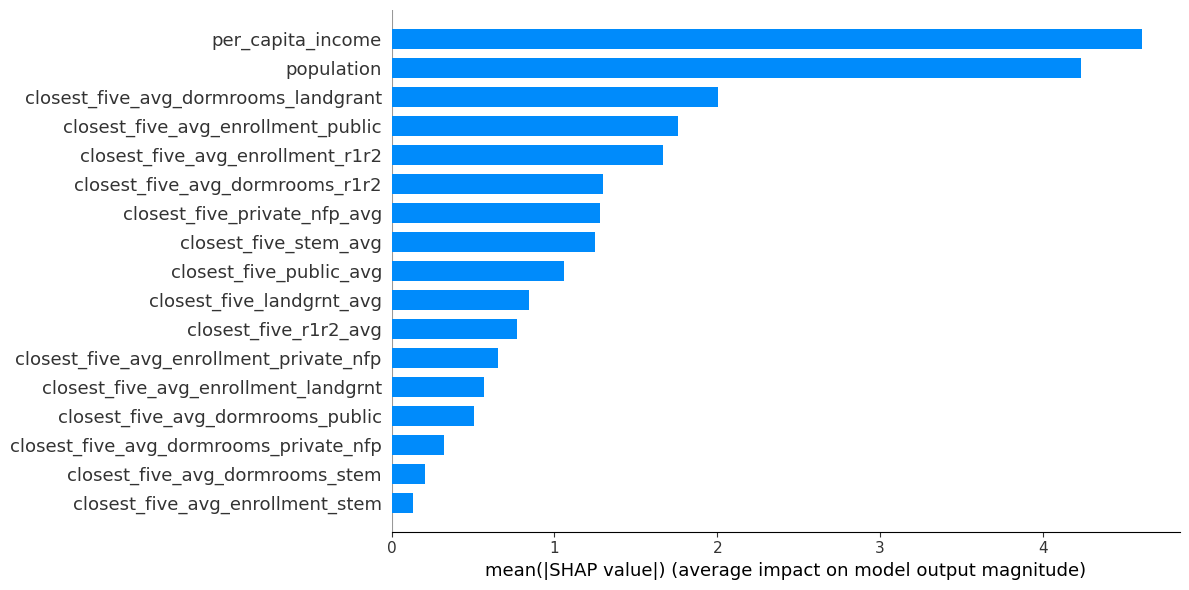

In [28]:
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
plt.show()
plt.close()

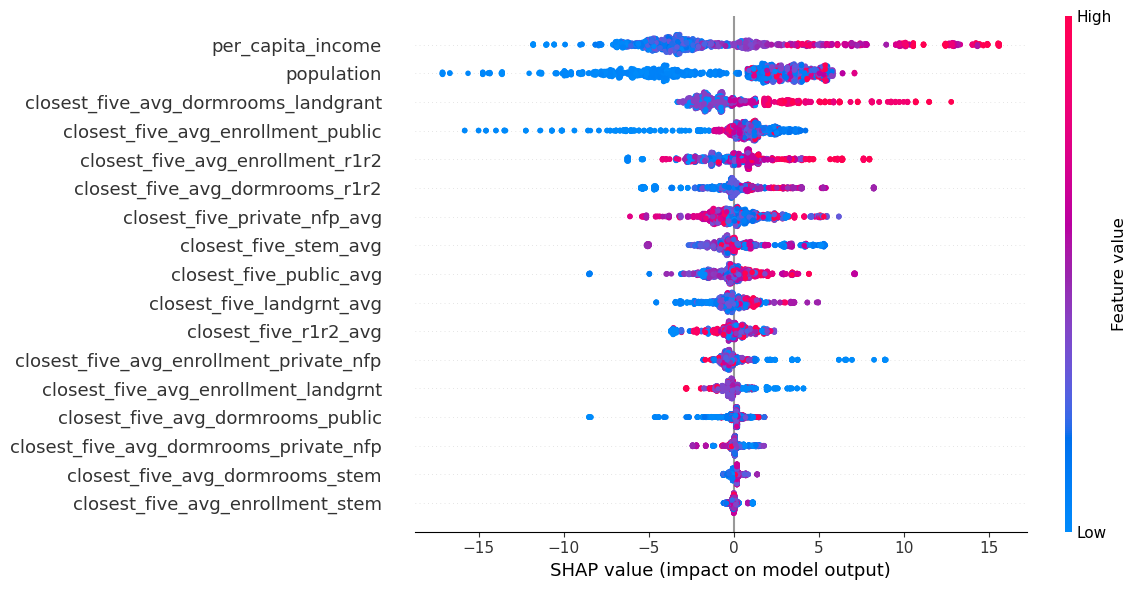

In [29]:
### the scatter plot
shap.summary_plot(shap_values, X_train, show=False, plot_size=[12, 6])
plt.show()
plt.close()